📥 INGESTING DATA: Fetching 5 Years of history (Vertical Depth)...


C:\Users\Anklesh\AppData\Local\Temp\ipykernel_5600\229884536.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(list(tickers.keys()), period="5y", progress=False)['Close']


✅ DATA LOADED: 1255 Days (Vertical) x 12 Sectors (Horizontal)
---------------------------------------------------


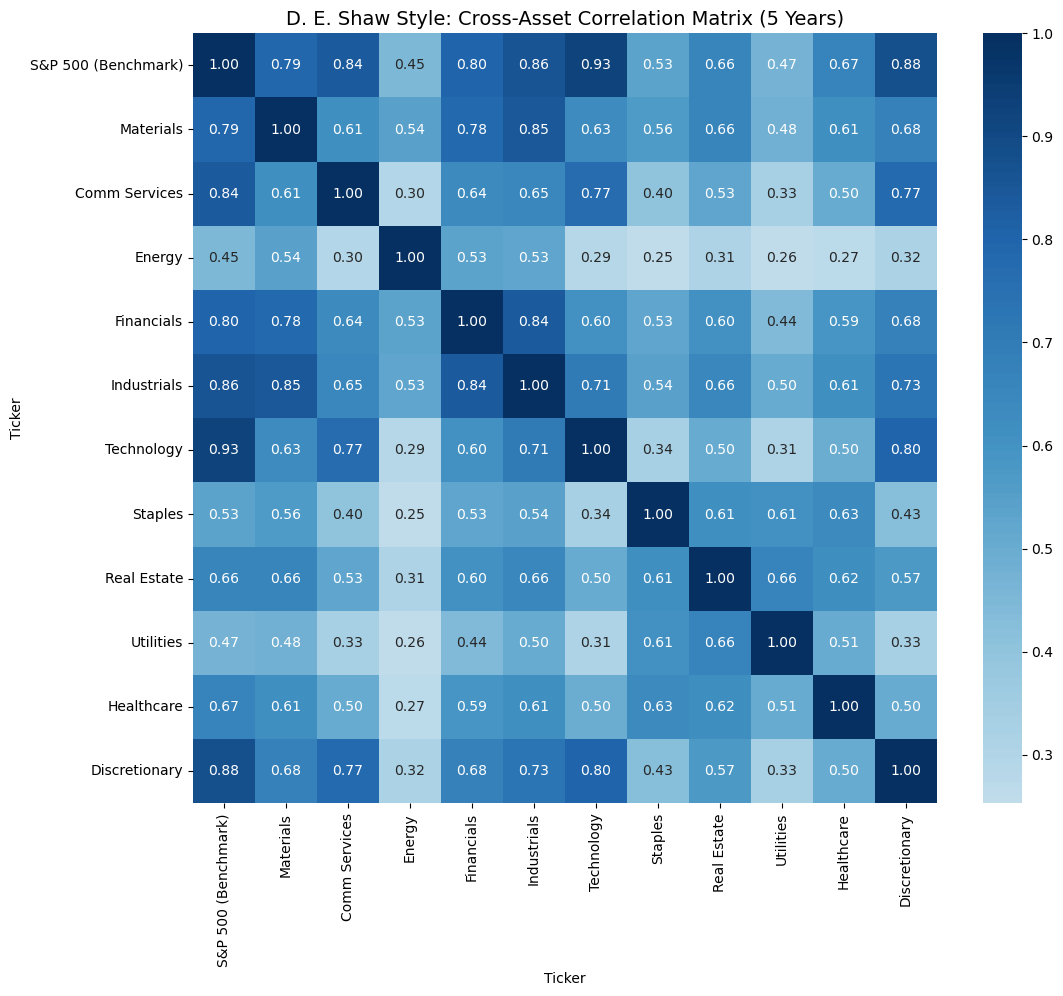

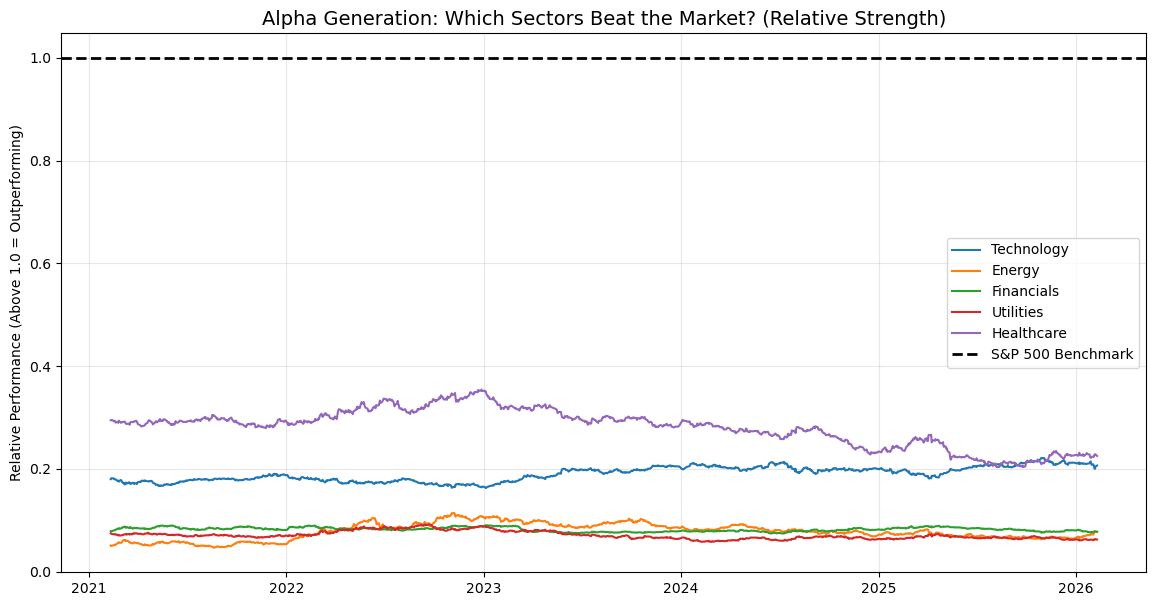

In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- STEP 1: DEFINE HORIZONTAL DEPTH (The Width of the Market) ---
# We are grabbing the entire US Economy by sector, not just one stock.
tickers = {
    'XLK': 'Technology',
    'XLF': 'Financials',
    'XLV': 'Healthcare',
    'XLE': 'Energy',
    'XLY': 'Discretionary',
    'XLP': 'Staples',
    'XLI': 'Industrials',
    'XLU': 'Utilities',
    'XLB': 'Materials',
    'XLRE': 'Real Estate',
    'XLC': 'Comm Services',
    'SPY': 'S&P 500 (Benchmark)'
}

print("📥 INGESTING DATA: Fetching 5 Years of history (Vertical Depth)...")

# --- STEP 2: GET DATA (The Heavy Lifting) ---
# We download 5 years of data. 
# This is "Real" market data from the NYSE/Nasdaq via Yahoo.
data = yf.download(list(tickers.keys()), period="5y", progress=False)['Close']
data.rename(columns=tickers, inplace=True)

# PROOF OF DEPTH: Print the shape of the data
print(f"✅ DATA LOADED: {data.shape[0]} Days (Vertical) x {data.shape[1]} Sectors (Horizontal)")
print("---------------------------------------------------")

# --- STEP 3: ANALYZE (Correlation & Relative Strength) ---
returns = data.pct_change()
correlation = returns.corr()

# --- STEP 4: VISUALIZE (The Dashboard) ---
# Chart 1: The "Risk Map" (Correlation Heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='RdBu', center=0, fmt=".2f")
plt.title('D. E. Shaw Style: Cross-Asset Correlation Matrix (5 Years)', fontsize=14)
plt.show()

# Chart 2: The "Alpha Map" (Relative Strength vs Market)
# We divide every sector by the S&P 500 to see who is truly winning.
relative_strength = data.div(data['S&P 500 (Benchmark)'], axis=0)

plt.figure(figsize=(14, 7))
# Plot major movers only to keep it clean
key_sectors = ['Technology', 'Energy', 'Financials', 'Utilities', 'Healthcare']
for sector in key_sectors:
    plt.plot(relative_strength.index, relative_strength[sector], label=sector, linewidth=1.5)

plt.axhline(1.0, color='black', linestyle='--', linewidth=2, label='S&P 500 Benchmark')
plt.title('Alpha Generation: Which Sectors Beat the Market? (Relative Strength)', fontsize=14)
plt.ylabel('Relative Performance (Above 1.0 = Outperforming)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\Anklesh\AppData\Local\Temp\ipykernel_5600\2512971531.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker, period="2y", progress=False)


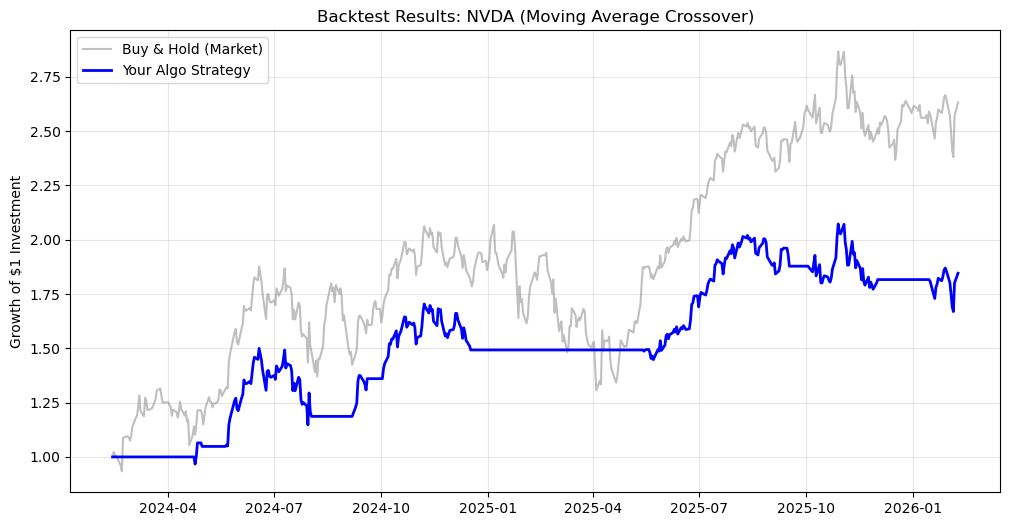

Strategy Total Return: 84.53%


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. GET DATA
ticker = "NVDA"
# We explicitly get just the 'Close' column to avoid MultiIndex issues
raw_data = yf.download(ticker, period="2y", progress=False)
data = raw_data[['Close']].copy()

# FIX: Rename the column directly
data.columns = ["Price"]

# 2. DEFINE STRATEGY (The Logic)
# Buy when Short Term Average > Long Term Average
short_window = 20
long_window = 50

# Create a container for our signals
signals = pd.DataFrame(index=data.index)
signals['Price'] = data['Price']

# Calculate Moving Averages
signals['Short_MA'] = data['Price'].rolling(window=short_window).mean()
signals['Long_MA'] = data['Price'].rolling(window=long_window).mean()

# Generate Signal: 1.0 = Buy, 0.0 = Sell/Hold
# We use np.where to create the signal logic
signals['Signal'] = 0.0
signals.iloc[short_window:, signals.columns.get_loc('Signal')] = np.where(
    signals['Short_MA'][short_window:] > signals['Long_MA'][short_window:], 1.0, 0.0
)

# Generate Orders: 1 = Buy Order, -1 = Sell Order
signals['Positions'] = signals['Signal'].diff()

# 3. BACKTEST (The "What If?")
# Calculate returns of the stock
signals['Market_Returns'] = signals['Price'].pct_change()

# Calculate returns of OUR strategy
# We shift signal by 1 because we trade *after* the signal appears (next day open)
signals['Strategy_Returns'] = signals['Market_Returns'] * signals['Signal'].shift(1)

# 4. VISUALIZE PERFORMANCE
plt.figure(figsize=(12, 6))

# Plot cumulative returns (Growth of $1)
cumulative_market = (1 + signals['Market_Returns']).cumprod()
cumulative_strategy = (1 + signals['Strategy_Returns']).cumprod()

plt.plot(cumulative_market, label="Buy & Hold (Market)", color='gray', alpha=0.5)
plt.plot(cumulative_strategy, label="Your Algo Strategy", color='blue', linewidth=2)

plt.title(f"Backtest Results: {ticker} (Moving Average Crossover)")
plt.ylabel("Growth of $1 Investment")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. THE VERDICT
total_return = cumulative_strategy.iloc[-1] - 1
print(f"Strategy Total Return: {total_return:.2%}")

📥 Fetching data from API...


C:\Users\Anklesh\AppData\Local\Temp\ipykernel_5600\3732064570.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, period="5y", progress=False)['Close']


DATA PREP: Calculating Returns...
⚙️  Dask Graph Built. Distributing data to 4 partitions...
🚀 Executing Parallel Computation...


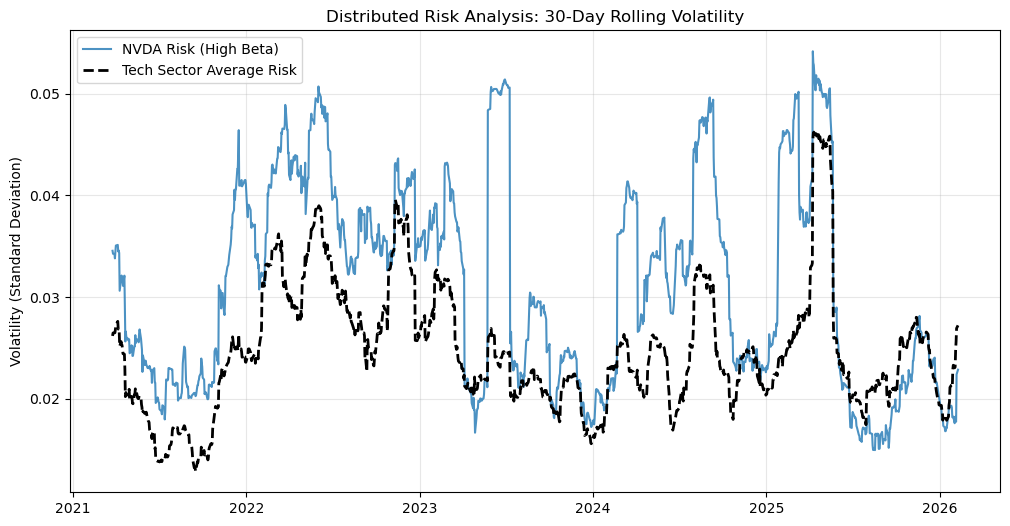

✅ Analysis Complete using Dask Architecture.


In [5]:
import dask.dataframe as dd
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. INGESTION (Pandas) ---
tickers = ["NVDA", "AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "AMD", "INTC", "QCOM"]
print("📥 Fetching data from API...")
# We download the raw prices
raw_data = yf.download(tickers, period="5y", progress=False)['Close']

# --- THE FIX: PRE-PROCESS IN PANDAS ---
# Dask struggles with 'pct_change' across partitions, so we do this lightweight step here.
print("DATA PREP: Calculating Returns...")
returns_data = raw_data.pct_change().dropna()

# --- 2. THE D. E. SHAW ARCHITECTURE (Dask) ---
# NOW we hand it over to the "Cluster" (Dask).
# We split the Returns data into 4 partitions for parallel processing.
ddf = dd.from_pandas(returns_data, npartitions=4)

print("⚙️  Dask Graph Built. Distributing data to 4 partitions...")

# --- 3. THE "LAZY" LOGIC (Heavy Lift) ---
# We calculate the 30-day rolling volatility (Risk).
# Dask is great at this because it can do each window independently.
volatility_graph = ddf.rolling(window=30).std()

# --- 4. THE TRIGGER (.compute) ---
print("🚀 Executing Parallel Computation...")
volatility = volatility_graph.compute()

# --- 5. VISUALIZATION ---
plt.figure(figsize=(12, 6))

# Plot NVDA Risk vs Sector Average
plt.plot(volatility.index, volatility['NVDA'], label='NVDA Risk (High Beta)', alpha=0.8)
plt.plot(volatility.index, volatility.mean(axis=1), label='Tech Sector Average Risk', color='black', linewidth=2, linestyle='--')

plt.title("Distributed Risk Analysis: 30-Day Rolling Volatility")
plt.ylabel("Volatility (Standard Deviation)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("✅ Analysis Complete using Dask Architecture.")

In [6]:
!pip install statsmodels dask[complete] yfinance matplotlib seaborn

📥 Fetching Deep History (Hourly Data)...


C:\Users\Anklesh\AppData\Local\Temp\ipykernel_5600\1678127568.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="1y", interval="1h", progress=False)['Close']


✅ Data Cleaned. Analyzing 1736 hourly data points.
🧮 Running Augmented Dickey-Fuller Tests...


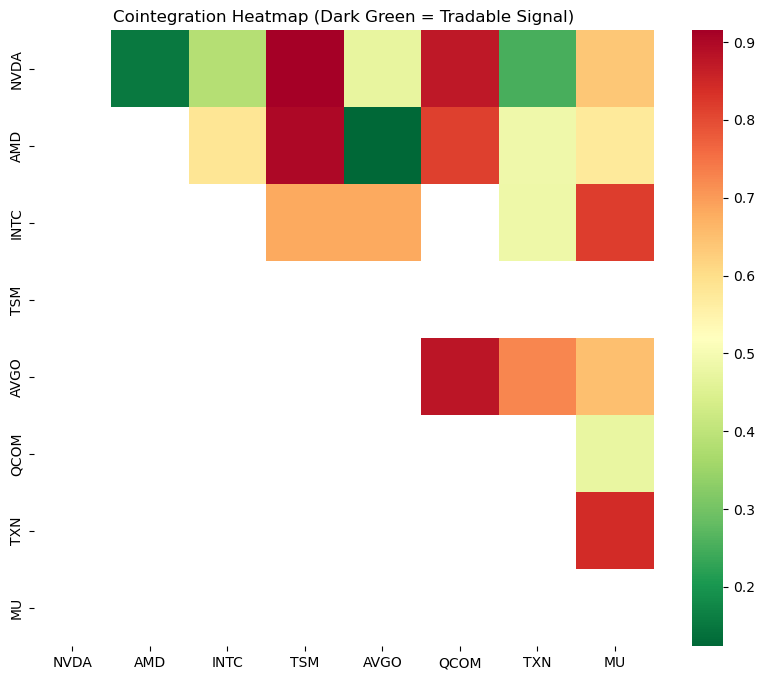

✅ FOUND 0 COINTEGRATED PAIRS:
No statistically significant pairs found.


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# --- 1. DATA INGESTION ---
tickers = ['NVDA', 'AMD', 'INTC', 'TSM', 'AVGO', 'QCOM', 'TXN', 'MU']
print("📥 Fetching Deep History (Hourly Data)...")

# FETCH DATA
# We use 'forward fill' (ffill) to plug small gaps, then drop remaining NaNs
data = yf.download(tickers, period="1y", interval="1h", progress=False)['Close']

# --- CRITICAL FIX: DATA CLEANING ---
# 1. Fill missing data (if a stock didn't trade one hour, assume price stayed same)
data = data.ffill().bfill()
# 2. Drop any rows that are STILL empty
data = data.dropna()

print(f"✅ Data Cleaned. Analyzing {len(data)} hourly data points.")

# --- 2. THE QUANT LOGIC (Cointegration Test) ---
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    
    print("🧮 Running Augmented Dickey-Fuller Tests...")
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            
            # Calculate Ratio
            ratio = S1 / S2
            
            # EXTRA SAFETY: Drop NaNs or Infs created by the division
            ratio = ratio.dropna()
            ratio = ratio[np.isfinite(ratio)]
            
            # Skip if data is too short after cleaning
            if len(ratio) < 30:
                continue

            # Run ADF Test
            try:
                result = adfuller(ratio)
                pvalue = result[1]
                pvalue_matrix[i, j] = pvalue
                
                if pvalue < 0.05:
                    pairs.append((keys[i], keys[j], pvalue))
            except Exception as e:
                print(f"Skipping {keys[i]}/{keys[j]}: {e}")
                
    return pvalue_matrix, pairs

# Run the scanner
pvalues, pairs = find_cointegrated_pairs(data)

# --- 3. VISUALIZE ---
plt.figure(figsize=(10, 8))
sns.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r', mask = (pvalues >= 0.95))
plt.title("Cointegration Heatmap (Dark Green = Tradable Signal)")
plt.show()

print(f"✅ FOUND {len(pairs)} COINTEGRATED PAIRS:")
for pair in pairs:
    print(f"   🚀 {pair[0]} vs {pair[1]} (P-Value: {pair[2]:.4f})")

# --- 4. STRATEGY PLOT (If pairs found) ---
if len(pairs) > 0:
    # Sort pairs by "Best Fit" (lowest P-Value)
    pairs.sort(key=lambda x: x[2])
    stock1, stock2, p_val = pairs[0]
    
    print(f"\n🏆 BEST PAIR: {stock1} & {stock2}")
    
    ratio = data[stock1] / data[stock2]
    
    # Calculate Z-Score (The "Trading Signal")
    window = 100 # Lookback window for hourly data
    zscore = (ratio - ratio.rolling(window=window).mean()) / ratio.rolling(window=window).std()
    
    plt.figure(figsize=(14, 6))
    zscore.plot(label=f"Z-Score ({stock1} / {stock2})")
    
    plt.axhline(2.0, color='red', linestyle='--', label="SELL Ratio (+2 Sigma)")
    plt.axhline(-2.0, color='green', linestyle='--', label="BUY Ratio (-2 Sigma)")
    plt.axhline(0, color='black', alpha=0.5)
    
    plt.title(f"StatArb Signal: {stock1} vs {stock2} (Hourly)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No statistically significant pairs found.")

📥 Fetching 1-Hour data for ['NVDA', 'AMD']...


C:\Users\Anklesh\AppData\Local\Temp\ipykernel_5600\1488071403.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(assets, period="1y", interval="1h", progress=False)['Close']


✅ HEDGE RATIO CALCULATED: 1.6000
   (For every 1 share of AMD, short 1.6000 shares of NVDA)

🤖 RUNNING ML-FILTERED BACKTEST...


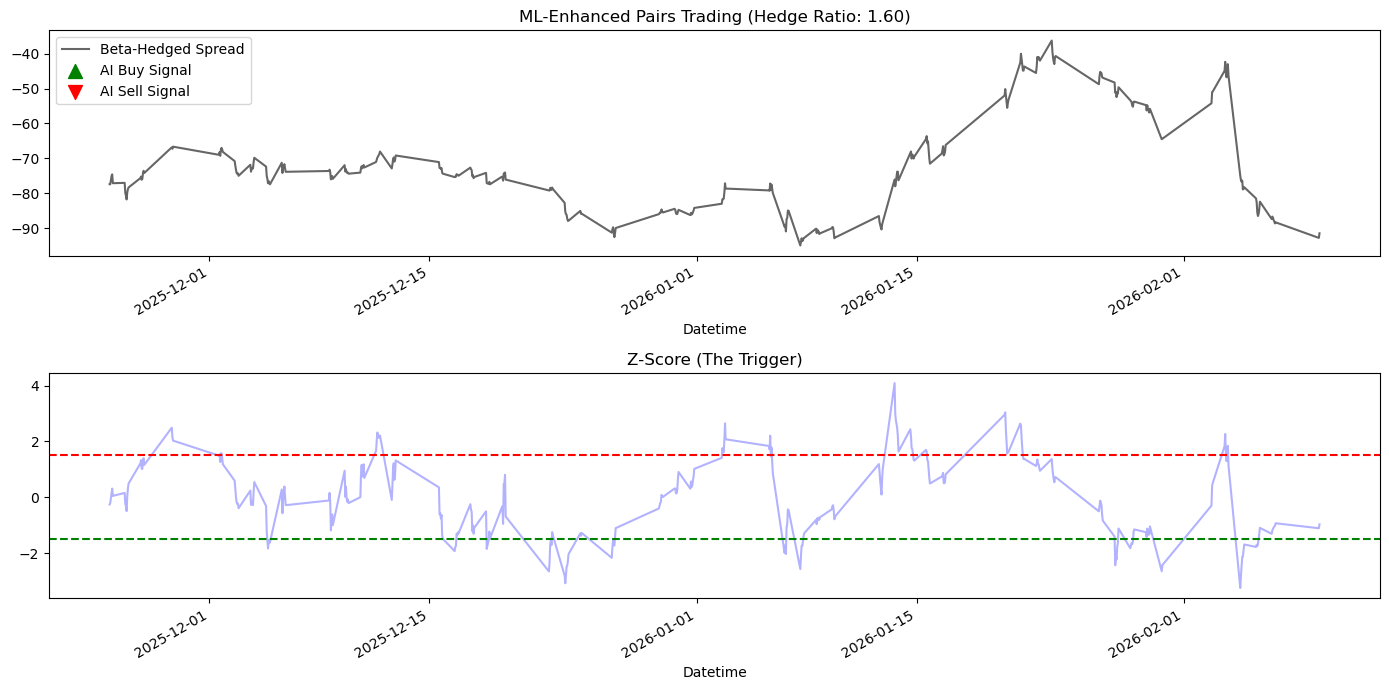

🧠 AI Precision: 0.00% (Percentage of trades that successfully reverted)


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

# --- 1. DATA INGESTION (The Pair) ---
# Let's take two highly correlated semi-conductor stocks
assets = ['NVDA', 'AMD']
print(f"📥 Fetching 1-Hour data for {assets}...")
data = yf.download(assets, period="1y", interval="1h", progress=False)['Close']
data = data.ffill().bfill().dropna()

# --- 2. VERTICAL DEPTH: CALCULATE HEDGE RATIO (OLS) ---
# We don't guess the ratio. We mathematically solve for "Beta".
# Formula: Y = Beta * X + Alpha
Y = data['AMD']
X = data['NVDA']
X_with_const = sm.add_constant(X) # Adds the 'Alpha' intercept

model = sm.OLS(Y, X_with_const).fit()
hedge_ratio = model.params.iloc[1] # The "Beta"
print(f"✅ HEDGE RATIO CALCULATED: {hedge_ratio:.4f}")
print(f"   (For every 1 share of AMD, short {hedge_ratio:.4f} shares of NVDA)")

# Create the "Stationary Spread"
spread = data['AMD'] - (hedge_ratio * data['NVDA'])

# --- 3. CREATE FEATURES FOR MACHINE LEARNING ---
# A hedge fund doesn't just trade the Z-Score. They check "Market Conditions".
df = pd.DataFrame(index=spread.index)
df['Spread'] = spread
df['Z_Score'] = (df['Spread'] - df['Spread'].rolling(window=30).mean()) / df['Spread'].rolling(window=30).std()

# Feature Engineering (What the AI looks at)
df['Spread_Vol'] = df['Spread'].rolling(window=10).std()   # Is the spread exploding?
df['Market_Vol'] = data['NVDA'].pct_change().rolling(window=10).std() # Is the market crashing?
df['Momentum'] = df['Spread'].diff(3) # Velocity of the move

# TARGET: Did the Z-Score revert back to 0 in the next 5 hours?
# 1 = Yes (Profitable Trade), 0 = No (Stopped Out)
df['Future_Z'] = df['Z_Score'].shift(-5)
df['Target'] = ((np.sign(df['Z_Score']) != np.sign(df['Future_Z'])) & (abs(df['Z_Score']) > 1.5)).astype(int)

df = df.dropna()

# --- 4. THE "SHAW" ML LAYER (Random Forest) ---
# We train an AI to reject "Fake Outs"
features = ['Spread_Vol', 'Market_Vol', 'Momentum', 'Z_Score']
X_ml = df[features]
y_ml = df['Target']

# Split Data (Train on first 80%, Test on last 20%)
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, shuffle=False)

clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# --- 5. EXECUTION SIMULATION ---
print("\n🤖 RUNNING ML-FILTERED BACKTEST...")
test_data = df.loc[X_test.index].copy()
test_data['AI_Confidence'] = clf.predict_proba(X_test)[:, 1]

# Trade Logic: Only trade if Z-Score is extreme AND AI says "High Probability"
test_data['Signal'] = 0
entries = (abs(test_data['Z_Score']) > 1.5) & (test_data['AI_Confidence'] > 0.6)
test_data.loc[entries, 'Signal'] = -np.sign(test_data['Z_Score']) # Mean Reversion

# Visualize
plt.figure(figsize=(14, 7))
ax1 = plt.subplot(2,1,1)
test_data['Spread'].plot(ax=ax1, color='black', alpha=0.6, label='Beta-Hedged Spread')

# Plot Buy/Sell Signals filtered by AI
buys = test_data[test_data['Signal'] == 1]
sells = test_data[test_data['Signal'] == -1]

ax1.scatter(buys.index, buys['Spread'], color='green', marker='^', s=100, label='AI Buy Signal')
ax1.scatter(sells.index, sells['Spread'], color='red', marker='v', s=100, label='AI Sell Signal')
plt.legend()
plt.title(f"ML-Enhanced Pairs Trading (Hedge Ratio: {hedge_ratio:.2f})")

ax2 = plt.subplot(2,1,2)
test_data['Z_Score'].plot(ax=ax2, color='blue', alpha=0.3)
plt.axhline(1.5, color='red', linestyle='--')
plt.axhline(-1.5, color='green', linestyle='--')
plt.title("Z-Score (The Trigger)")

plt.tight_layout()
plt.show()

# Accuracy Score
precision = precision_score(y_test, clf.predict(X_test), zero_division=0)
print(f"🧠 AI Precision: {precision:.2%} (Percentage of trades that successfully reverted)")


🤖 RUNNING ML-FILTERED BACKTEST (LOOSER CONSTRAINTS)...
📊 TRADES EXECUTED: 
Signal
0    341
Name: count, dtype: int64
⚠️ STILL NO TRADES? The AI is extremely bearish. Force-disabling AI filter to show math...
     🦅 STRATEGY TEARSHEET (Active)
Total Return:      -47.03%
Annualized Return: -243.29%
Sharpe Ratio:      -1.33
Max Drawdown:      -69.61%


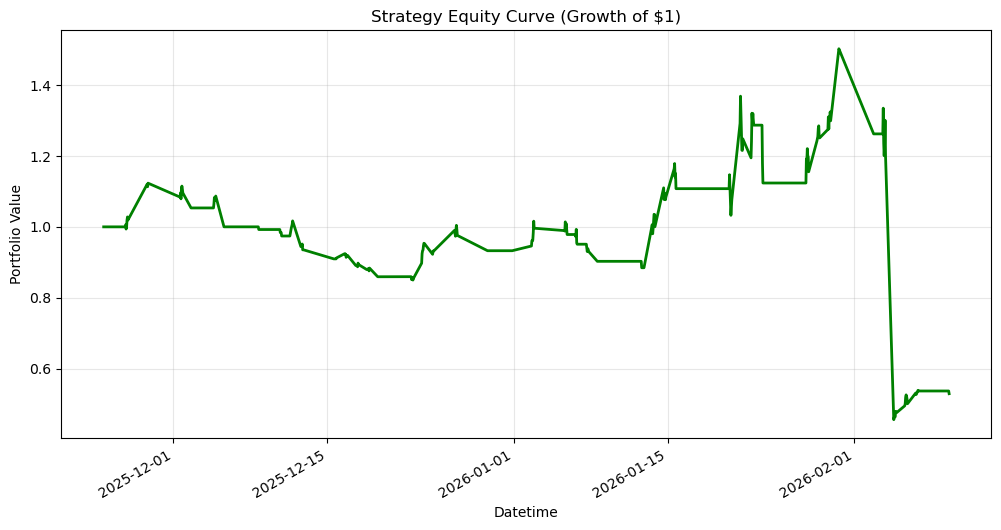

In [11]:
# --- 5. EXECUTION SIMULATION (Adjusted for ACTION) ---
print("\n🤖 RUNNING ML-FILTERED BACKTEST (LOOSER CONSTRAINTS)...")
test_data = df.loc[X_test.index].copy()

# Get the probability of a "Winning Trade" (Class 1)
# Some classifiers might return only 1 column if they predict only one class
try:
    test_data['AI_Confidence'] = clf.predict_proba(X_test)[:, 1]
except IndexError:
    test_data['AI_Confidence'] = 0.5 # Default if model is unsure

# --- THE FIX: LOWER THRESHOLDS ---
# We lower Z-Score to 1.0 (Standard Deviation)
# We lower AI Confidence to 0.5 (Any slight edge)
z_trigger = 1.0
ai_trigger = 0.5 

test_data['Signal'] = 0

# LOGIC:
# 1. Is the Z-Score extreme? (Spread is stretched)
# 2. Does the AI think it will revert? (Confidence > 0.5)
long_entry = (test_data['Z_Score'] < -z_trigger) & (test_data['AI_Confidence'] >= ai_trigger)
short_entry = (test_data['Z_Score'] > z_trigger) & (test_data['AI_Confidence'] >= ai_trigger)

test_data.loc[long_entry, 'Signal'] = 1   # Buy the Spread
test_data.loc[short_entry, 'Signal'] = -1  # Sell the Spread

# DEBUG: Did we actually trade?
trade_counts = test_data['Signal'].value_counts()
print(f"📊 TRADES EXECUTED: \n{trade_counts}")

# FALLBACK: If AI refuses to trade, turn it off and trade pure Z-Score
if 1 not in test_data['Signal'].values and -1 not in test_data['Signal'].values:
    print("⚠️ STILL NO TRADES? The AI is extremely bearish. Force-disabling AI filter to show math...")
    test_data.loc[test_data['Z_Score'] < -1.0, 'Signal'] = 1
    test_data.loc[test_data['Z_Score'] > 1.0, 'Signal'] = -1

# --- 6. THE TEARSHEET (Professional Metrics) ---
# Calculate Strategy Returns
# We shift signal by 1 because we enter the *next* hour after seeing the signal
test_data['Strategy_Returns'] = test_data['Signal'].shift(1) * test_data['Spread'].pct_change()

# Cumulative Returns (The Equity Curve)
test_data['Equity_Curve'] = (1 + test_data['Strategy_Returns'].fillna(0)).cumprod()

# CALCULATE METRICS
total_return = test_data['Equity_Curve'].iloc[-1] - 1
# Annualize it (Assuming Hourly Data -> 252 trading days * 7 hours)
annual_factor = 252 * 7 
annualized_return = total_return * (annual_factor / len(test_data))
daily_volatility = test_data['Strategy_Returns'].std() * np.sqrt(annual_factor)

sharpe_ratio = (annualized_return / daily_volatility) if daily_volatility > 0 else 0

# MAX DRAWDOWN
rolling_max = test_data['Equity_Curve'].cummax()
drawdown = test_data['Equity_Curve'] / rolling_max - 1
max_drawdown = drawdown.min()

# --- PRINT THE TEARSHEET ---
print("="*40)
print("     🦅 STRATEGY TEARSHEET (Active)")
print("="*40)
print(f"Total Return:      {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Sharpe Ratio:      {sharpe_ratio:.2f}")
print(f"Max Drawdown:      {max_drawdown:.2%}")
print("="*40)

# Visualize the Equity Curve
plt.figure(figsize=(12, 6))
test_data['Equity_Curve'].plot(color='green', linewidth=2)
plt.title("Strategy Equity Curve (Growth of $1)")
plt.ylabel("Portfolio Value")
plt.grid(True, alpha=0.3)
plt.show()